In [2]:
import pandas as pd
import numpy as np
 
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag 

import mygene

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import os
import requests

In [2]:
mfdf = pd.read_csv('../data/ontology/go_annotations_molecular_function.csv')
mfdf.head()


,Gene,Gene_Symbol,Type,GO_ID,Term,Evidence,Category
0,ENSG00000117410,ATP6V0B,Molecular_Function,GO:0005515,protein binding,IPI,MF
1,ENSG00000117410,ATP6V0B,Molecular_Function,GO:0015078,proton transmembrane transporter activity,IEA,MF
2,ENSG00000117410,ATP6V0B,Molecular_Function,GO:0046961,"proton-transporting ATPase activity, rotationa...",IEA,MF
3,ENSG00000117410,ATP6V0B,Molecular_Function,GO:0046961,"proton-transporting ATPase activity, rotationa...",TAS,MF
4,ENSG00000204520,MICA,Molecular_Function,GO:0005515,protein binding,IPI,MF


In [3]:
unique_genes = mfdf['Gene'].unique().tolist()

In [4]:
len(unique_genes)

3437

In [41]:
def get_versioned_ontology():
    # 1. Define the local target name (Versioned)
    today = datetime.now().strftime('%Y-%m-%d')
    local_filename = f"go-basic_{today}.obo"
    
    # 2. Define the static source URL (Always the same)
    url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
    
    # 3. Check if we already have it locally
    if os.path.exists(local_filename):
        print(f"Loading existing ontology: {local_filename}")
    else:
        print(f"Downloading new ontology from {url}...")
        print(f"Saving locally as {local_filename}...")
        
        # Manual Download to control the filename
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(local_filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
        else:
            raise ValueError(f"Server returned {response.status_code}. Could not download OBO file.")
        
    # 4. Load the DAG
    # load_obsolete=True is CRITICAL to find old IDs
    return GODag(local_filename, load_obsolete=True)

In [ ]:
# --- Initialize the DAG ---
#go_dag = get_versioned_ontology()

In [2]:
# get go_dag from the saved filename
go_dag = GODag('go-basic_2025-11-28.obo', load_obsolete=True, optional_attrs=['relationship'])

go-basic_2025-11-28.obo: fmt(1.2) rel(2025-10-10) 51,842 Terms; optional_attrs(relationship)


In [3]:
count_with_relations = 0
example_id = None
example_type = None

print("Scanning graph for relationships...")
for term in go_dag.values():
    if hasattr(term, 'relationship') and term.relationship:
        count_with_relations += 1
        if example_id is None:
            example_id = term.id
            example_type = list(term.relationship.keys())[0]

if count_with_relations == 0:
    print("\n[ERROR] The graph has ZERO relationships.")
    print("Check your get_versioned_ontology() function.")
    print("Make sure it has: optional_attrs=['relationship']")
else:
    print(f"\n[SUCCESS] Found {count_with_relations} terms with relationships.")
    print(f"Example: {example_id} has a '{example_type}' relation.")
    
    # 3. Print the example to prove it works
    term = go_dag[example_id]
    print(f"\n--- Details for {term.name} ---")
    print(f"Parents (is_a): {[p.id for p in term.parents]}")
    print(f"Relationships: {term.relationship}")

Scanning graph for relationships...

[SUCCESS] Found 15046 terms with relationships.
Example: GO:0000015 has a 'part_of' relation.

--- Details for phosphopyruvate hydratase complex ---
Parents (is_a): ['GO:1902494']
Relationships: {'part_of': {GOTerm('GO:0005829'):
  id:GO:0005829
  item_id:GO:0005829
  name:cytosol
  namespace:cellular_component
  _parents: 1 items
    GO:0110165
  parents: 1 items
    GO:0110165	level-01	depth-01	cellular anatomical structure [cellular_component]
  children: 1 items
    GO:0099522	level-03	depth-03	cytosolic region [cellular_component]
  level:2
  depth:2
  is_obsolete:False
  alt_ids: 0 items
  relationship: 1 items
    part_of: 1 items
      GO:0005737	level-02	depth-02	cytoplasm [cellular_component]
  relationship_rev: 1 items
    part_of: 44 items
      GO:0072379	level-02	depth-02	ER membrane insertion complex [cellular_component]
      GO:1990588	level-03	depth-03	FtsBL complex [cellular_component]
      GO:0005832	level-04	depth-04	chaperonin

In [ ]:
# 2. Counters
total_terms = 0
terms_with_relations = 0
relation_types_found = set()

print("Auditing Graph...")

for term in go_dag.values():
    total_terms += 1
    if hasattr(term, 'relationship') and term.relationship:
        terms_with_relations += 1
        # Record what types we found (regulates, part_of, etc.)
        for key in term.relationship.keys():
            relation_types_found.add(key)

print(f"\nTotal Terms in DAG: {total_terms}")
print(f"Terms with Typed Relationships: {terms_with_relations}")
print(f"Relationship Types Found: {relation_types_found}")

if terms_with_relations == 0:
    print("\n[DIAGNOSIS]: Your DAG object DOES NOT have relationships loaded.")
    print("Please check your get_versioned_ontology function ensures optional_attrs=['relationship']")
else:
    print("\n[DIAGNOSIS]: The DAG is fine! Your genes simply map to terms that only use 'is_a' logic.")

Auditing Graph...

Total Terms in DAG: 51842
Terms with Typed Relationships: 15046
Relationship Types Found: {'regulates', 'part_of', 'negatively_regulates', 'positively_regulates'}

[DIAGNOSIS]: The DAG is fine! Your genes simply map to terms that only use 'is_a' logic.


In [4]:
# Ensure your DAG is loaded with relationships!
# go_dag = get_versioned_ontology() 

def get_regulatory_targets(go_id):
    if go_id not in go_dag:
        print(f"ID {go_id} not found.")
        return

    term = go_dag[go_id]
    print(f"Checking: {term.name} ({term.id})")
    
    # These are the 3 keys that represent regulation
    reg_keys = ['regulates', 'positively_regulates', 'negatively_regulates']
    found_any = False

    if hasattr(term, 'relationship'):
        for key in reg_keys:
            if key in term.relationship:
                targets = term.relationship[key]
                for target in targets:
                    print(f"  [{key}] -> {target.name} ({target.id})")
                    found_any = True
    
    if not found_any:
        print("  This term does not regulate anything (or relationships weren't loaded).")

# --- TEST CASE ---
# "Regulation of apoptotic process" (GO:0042981) should regulate "Apoptotic process"
get_regulatory_targets("GO:0042981")

Checking: regulation of apoptotic process (GO:0042981)
  [regulates] -> apoptotic process (GO:0006915)


In [7]:
not_found_genes = []
genes_with_no_mf, genes_with_no_bp = [], []

def fetch_go_data(gene_list):
    mg = mygene.MyGeneInfo()
    
    # 1. Query fields
    # We ask for go.BP (Process) and go.MF (Function)
    results = mg.querymany(gene_list, 
                           scopes='ensembl.gene', 
                           fields='symbol,go.BP,go.MF', 
                           species='human')
    
    bp_data, mf_data = [], []
    
    for item in results:
        gene = item.get('query')
        symbol = item.get('symbol', 'Unknown')
        # Skip if no GO data found
        if 'go' not in item:
            not_found_genes.append(gene)
            continue
            
        # 2. Extract Biological Process (BP) - "The Big Picture"
        # We normalize because sometimes it returns a dict (1 result) or list (many results)
        bp_raw = item['go'].get('BP', [])
        if isinstance(bp_raw, list) and len(bp_raw) == 0:
            genes_with_no_bp.append(gene)
        if isinstance(bp_raw, dict): bp_raw = [bp_raw]
        
        for entry in bp_raw:
            go_id = entry.get('id')
            level, depth = get_term_metrics(go_id)
            bp_data.append({
                'Gene': gene,
                'Gene_Symbol': symbol,
                'Type': 'Biological_Process',
                'GO_ID': go_id,
                'Term': entry.get('term'),
                'Evidence': entry.get('evidence'),
                'Category': 'BP',
                'Level': level,
                'Depth': depth
            })
            
        # 3. Extract Molecular Function (MF) - "The Mechanism"
        mf_raw = item['go'].get('MF', [])
        if isinstance(mf_raw, list) and len(mf_raw) == 0:
            genes_with_no_mf.append(gene)
        if isinstance(mf_raw, dict): mf_raw = [mf_raw]
        
        for entry in mf_raw:
            go_id = entry.get('id')
            level, depth = get_term_metrics(go_id)
            mf_data.append({
                'Gene': gene,
                'Gene_Symbol': symbol,
                'Type': 'Molecular_Function',
                'GO_ID': go_id,
                'Term': entry.get('term'),
                'Evidence': entry.get('evidence'),
                'Level': level,
                'Depth': depth,
                'Category': 'MF'
            })

    return pd.DataFrame(bp_data), pd.DataFrame(mf_data)

In [9]:
bp_df, mf_df = fetch_go_data(unique_genes)
bp_df.head()

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


,Gene,Gene_Symbol,Type,GO_ID,Term,Evidence,Category,Level,Depth
0,ENSG00000117410,ATP6V0B,Biological_Process,GO:0006811,monoatomic ion transport,IEA,BP,4,4
1,ENSG00000117410,ATP6V0B,Biological_Process,GO:0007035,vacuolar acidification,NAS,BP,5,9
2,ENSG00000117410,ATP6V0B,Biological_Process,GO:0007042,lysosomal lumen acidification,NAS,BP,5,10
3,ENSG00000117410,ATP6V0B,Biological_Process,GO:0016241,regulation of macroautophagy,NAS,BP,7,7
4,ENSG00000117410,ATP6V0B,Biological_Process,GO:0048388,endosomal lumen acidification,NAS,BP,5,9


In [10]:
len(genes_with_no_bp), len(genes_with_no_mf)

(120, 0)

In [11]:
bp_df.Gene.nunique()

3317

In [ ]:
#bp_df.to_csv('../data/ontology/go_annotations_biological_process_{}.csv'.format(pd.Timestamp.now().strftime('%Y-%m-%d')), index=False)

In [13]:
p = 3437 - 120 # number of unique genes to be annotated - genes with no BP in the GO 
print(f"Percentage of the genes without BP: {120 / 3437:.2%}") 


Percentage of the genes without BP: 3.49%


In [14]:
mf_df.shape

(27091, 9)

In [15]:
bp_df.shape

(41949, 9)

In [16]:
bp_df.Level.value_counts()

Level
5     9280
6     7820
4     6882
7     6070
3     3715
8     3225
9     1881
2     1281
10    1163
11     362
1      158
0       86
13      15
12      11
Name: count, dtype: int64

In [62]:
mf_df.Level.value_counts()

Level
3    6693
2    6514
4    5482
5    4776
6    1921
7    1267
1     332
8      89
9      10
0       7
Name: count, dtype: int64

In [63]:
mf_df.Depth.value_counts()

Depth
2     6116
3     5072
4     4664
5     4320
6     2587
7     2364
8     1416
1      332
9      139
11      40
10      34
0        7
Name: count, dtype: int64

In [46]:
mf_df.shape

(27091, 9)

In [3]:
# get go_dag from the saved filename
go_dag = GODag('go-basic_2025-11-28.obo', load_obsolete=True, optional_attrs=['relationship'])

go-basic_2025-11-28.obo: fmt(1.2) rel(2025-10-10) 51,842 Terms; optional_attrs(relationship)


In [3]:
#mf_df.to_csv('../data/ontology/go_annotations_molecular_{}.csv'.format(pd.Timestamp.now().strftime('%Y-%m-%d')), index=False)
mf_df = pd.read_csv("../data/ontology/go_annotations_molecular_2025-11-28.csv", index_col=None)
mf_df.head()

,Gene,Gene_Symbol,Type,GO_ID,Term,Evidence,Level,Depth,Category
0,ENSG00000117410,ATP6V0B,Molecular_Function,GO:0005515,protein binding,IPI,2,2,MF
1,ENSG00000117410,ATP6V0B,Molecular_Function,GO:0015078,proton transmembrane transporter activity,IEA,5,5,MF
2,ENSG00000117410,ATP6V0B,Molecular_Function,GO:0046961,"proton-transporting ATPase activity, rotationa...",IEA,4,8,MF
3,ENSG00000117410,ATP6V0B,Molecular_Function,GO:0046961,"proton-transporting ATPase activity, rotationa...",TAS,4,8,MF
4,ENSG00000204520,MICA,Molecular_Function,GO:0005515,protein binding,IPI,2,2,MF


In [12]:
bp_df = pd.read_csv("../data/ontology/go_annotations_biological_process_2025-11-30.csv", index_col=None)
bp_df.head()

,Gene,Gene_Symbol,Type,GO_ID,Term,Evidence,Category,Level,Depth
0,ENSG00000117410,ATP6V0B,Biological_Process,GO:0006811,monoatomic ion transport,IEA,BP,4,4
1,ENSG00000117410,ATP6V0B,Biological_Process,GO:0007035,vacuolar acidification,NAS,BP,5,9
2,ENSG00000117410,ATP6V0B,Biological_Process,GO:0007042,lysosomal lumen acidification,NAS,BP,5,10
3,ENSG00000117410,ATP6V0B,Biological_Process,GO:0016241,regulation of macroautophagy,NAS,BP,7,7
4,ENSG00000117410,ATP6V0B,Biological_Process,GO:0048388,endosomal lumen acidification,NAS,BP,5,9


In [45]:
bp_df.Gene.nunique()

3317

In [39]:
def get_regulatory_targets(go_id):
    """
    Finds all regulatory targets for a given GO ID.
    
    This modified version returns all targets and uses a consistent
    return type to make it more robust and easier to use.
    """
    if go_id not in go_dag:
        print(f"ID {go_id} not found.")
        # Always return a tuple with a list to be consistent
        return None, []

    term = go_dag[go_id]
    found_targets = []
    
    # These are the 3 keys that represent regulation
    reg_keys = ['regulates', 'positively_regulates', 'negatively_regulates']

    if hasattr(term, 'relationship'):
        for key in reg_keys:
            if key in term.relationship:
                # A relationship can have one or multiple targets. 
                # We normalize to a list to handle both cases.
                targets = term.relationship[key]
                if not isinstance(targets, (list, set)):
                    targets = [targets]

                for target in targets:
                    #print(f"  [{key}] -> {target.name} ({target.id})")
                    # Store all relevant info for each target found
                    found_targets.append({
                        'regulator_id': term.id,
                        'regulator_name': term.name,
                        'regulation_type': key,
                        'target_id': target.id,
                        'target_name': target.name
                    })
    
    # Return the original term and the list of all targets found
    return term, found_targets


In [46]:
unique_terms = mf_df['Term'].unique().tolist()
unique_term_IDs = mf_df['GO_ID'].unique().tolist()
print("Total unique terms:", len(unique_terms))
print("Total unique term IDs:", len(unique_term_IDs))

NameError: name 'mf_df' is not defined

In [11]:
# Initialize lists to store the results for MF
mf_regulatory_relationships = []
mf_go_id_not_found = []

# Loop over the unique Molecular Function GO IDs
for go_id in unique_term_IDs:
    term, found_targets = get_regulatory_targets(go_id)
    
    # If the term is None, the ID was not found in the DAG
    if term is None:
        mf_go_id_not_found.append(go_id)
    
    # If the list of found_targets is not empty, extend our main list with its contents
    elif found_targets:
        mf_regulatory_relationships.extend(found_targets)

print(f"For MF: Found {len(mf_regulatory_relationships)} total regulatory relationships.")
print(f"For MF: Could not find {len(mf_go_id_not_found)} GO IDs in the DAG.")

For MF: Found 0 total regulatory relationships.
For MF: Could not find 0 GO IDs in the DAG.


In [47]:
unique_bp_terms = bp_df['Term'].unique().tolist()
unique_bp_term_IDs = bp_df['GO_ID'].unique().tolist()
print("Total unique biological process terms:", len(unique_bp_terms))
print("Total unique biological process term IDs:", len(unique_bp_term_IDs))

Total unique biological process terms: 6435
Total unique biological process term IDs: 6435


In [48]:
# Initialize lists to store the results for BP
bp_regulatory_relationships = []
bp_go_id_not_found = []

# Loop over the unique Biological Process GO IDs
for go_id in unique_bp_term_IDs:
    term, found_targets = get_regulatory_targets(go_id)
    
    # If the term is None, the ID was not found in the DAG
    if term is None:
        bp_go_id_not_found.append(go_id)
    
    # If the list of found_targets is not empty, extend our main list with its contents
    elif found_targets:
        bp_regulatory_relationships.extend(found_targets)

print(f"For BP: Found {len(bp_regulatory_relationships)} total regulatory relationships.")
print(f"For BP: Could not find {len(bp_go_id_not_found)} GO IDs in the DAG.")

For BP: Found 2068 total regulatory relationships.
For BP: Could not find 0 GO IDs in the DAG.


In [15]:
# Convert the list of BP relationships into a DataFrame
if bp_regulatory_relationships:
    bp_reg_df = pd.DataFrame(bp_regulatory_relationships)
    print("Biological Process Regulatory Relationships DataFrame:")
else:
    print("No regulatory relationships were found for Biological Process; an empty DataFrame will be created.")
    bp_reg_df = pd.DataFrame()

Biological Process Regulatory Relationships DataFrame:


In [18]:
# Save the Biological Process regulatory relationships
'''bp_reg_df.to_csv(
    '../data/ontology/go_regulatory_relationships_biological_process_{}.csv'.format(pd.Timestamp.now().strftime('%Y-%m-%d')), 
    index=False
)'''

"bp_reg_df.to_csv(\n    '../data/ontology/go_regulatory_relationships_biological_process_{}.csv'.format(pd.Timestamp.now().strftime('%Y-%m-%d')), \n    index=False\n)"

In [6]:
bp_reg_df = pd.read_csv('../data/ontology/go_regulatory_relationships_biological_process_2025-11-30.csv', 
    index_col=None)

In [49]:
bp_reg_df.head()

,regulator_id,regulator_name,regulation_type,target_id,target_name
0,GO:0016241,regulation of macroautophagy,regulates,GO:0016236,macroautophagy
1,GO:0031348,negative regulation of defense response,negatively_regulates,GO:0006952,defense response
2,GO:0032815,negative regulation of natural killer cell act...,negatively_regulates,GO:0030101,natural killer cell activation
3,GO:0045953,negative regulation of natural killer cell med...,negatively_regulates,GO:0042267,natural killer cell mediated cytotoxicity
4,GO:0050776,regulation of immune response,regulates,GO:0006955,immune response


In [50]:
bp_reg_df.shape

(2068, 5)

In [14]:
bp_reg_df.regulator_id.nunique(), bp_reg_df.target_id.nunique()

(2068, 1180)

In [15]:
unique_terms = mf_df['Term'].unique().tolist()
unique_term_IDs = mf_df['GO_ID'].unique().tolist()
print("Total unique terms:", len(unique_terms))
print("Total unique term IDs:", len(unique_term_IDs))

Total unique terms: 2147
Total unique term IDs: 2147


In [13]:
bp_df.shape

(41949, 9)

In [14]:
bp_df.head()

,Gene,Gene_Symbol,Type,GO_ID,Term,Evidence,Category,Level,Depth
0,ENSG00000117410,ATP6V0B,Biological_Process,GO:0006811,monoatomic ion transport,IEA,BP,4,4
1,ENSG00000117410,ATP6V0B,Biological_Process,GO:0007035,vacuolar acidification,NAS,BP,5,9
2,ENSG00000117410,ATP6V0B,Biological_Process,GO:0007042,lysosomal lumen acidification,NAS,BP,5,10
3,ENSG00000117410,ATP6V0B,Biological_Process,GO:0016241,regulation of macroautophagy,NAS,BP,7,7
4,ENSG00000117410,ATP6V0B,Biological_Process,GO:0048388,endosomal lumen acidification,NAS,BP,5,9


In [15]:
def get_specificity_metrics_with_rescue(go_id):
    # 1. Check if ID exists in the file
    if go_id not in go_dag:
        return None, None, None, "Missing"
    
    term = go_dag[go_id]
    
    # 2. THE RESCUE LOGIC: Check if Obsolete
    if term.is_obsolete:
        # Check if there is a "replaced_by" forwarding address
        # Note: replaced_by is a list (e.g., ['GO:0005515'])
        if hasattr(term, 'replaced_by') and term.replaced_by:
            new_id = term.replaced_by[0] # Grab the first replacement
            
            # Recursive Call: Get metrics for the NEW ID
            # We return the NEW ID so you can update your dataframe
            l, d, dent, status = get_specificity_metrics_with_rescue(new_id)
            return l, d, dent, f"Rescued ({new_id})"
            
        else:
            # It's dead with no forwarding address
            return None, None, None, "Dead"

    # 3. Calculate Metrics for Valid Terms
    descendants = term.get_all_children()
    
    return term.level, term.depth, len(descendants), "Valid"

In [16]:
# --- USAGE ON DATAFRAME ---
# Apply this to your dataframe to fill in the zeros
print("Rescuing obsolete terms...")

rescue_data = []

# Iterate over your specific "Problem Rows" (or the whole DF)
for index, row in bp_df.iterrows():
    l, d, dent, status = get_specificity_metrics_with_rescue(row['GO_ID'])
    
    rescue_data.append({
        'Original_ID': row['GO_ID'],
        'Level': l,
        'Depth': d,
        'Descendants': dent,
        'Status': status
    })

Rescuing obsolete terms...


In [17]:
df_results = pd.DataFrame(rescue_data)
print(df_results['Status'].value_counts())

Status
Valid    41868
Dead        81
Name: count, dtype: int64


In [57]:
df_results

,Original_ID,Level,Depth,Descendants,Status
0,GO:0006811,4.0,4.0,147.0,Valid
1,GO:0007035,5.0,9.0,1.0,Valid
2,GO:0007042,5.0,10.0,0.0,Valid
3,GO:0016241,7.0,7.0,24.0,Valid
4,GO:0048388,5.0,9.0,0.0,Valid
...,...,...,...,...,...
41944,GO:0045604,5.0,6.0,10.0,Valid
41945,GO:0070936,11.0,11.0,0.0,Valid
41946,GO:0071353,6.0,6.0,0.0,Valid
41947,GO:1902883,5.0,6.0,3.0,Valid


In [18]:
bp_df.shape

(41949, 9)

In [19]:
bp_df['specificity'], bp_df['Status'] = df_results['Descendants'], df_results['Status']
bp_df

,Gene,Gene_Symbol,Type,GO_ID,Term,Evidence,Category,Level,Depth,specificity,Status
0,ENSG00000117410,ATP6V0B,Biological_Process,GO:0006811,monoatomic ion transport,IEA,BP,4,4,147.0,Valid
1,ENSG00000117410,ATP6V0B,Biological_Process,GO:0007035,vacuolar acidification,NAS,BP,5,9,1.0,Valid
2,ENSG00000117410,ATP6V0B,Biological_Process,GO:0007042,lysosomal lumen acidification,NAS,BP,5,10,0.0,Valid
3,ENSG00000117410,ATP6V0B,Biological_Process,GO:0016241,regulation of macroautophagy,NAS,BP,7,7,24.0,Valid
4,ENSG00000117410,ATP6V0B,Biological_Process,GO:0048388,endosomal lumen acidification,NAS,BP,5,9,0.0,Valid
...,...,...,...,...,...,...,...,...,...,...,...
41944,ENSG00000079999,KEAP1,Biological_Process,GO:0045604,regulation of epidermal cell differentiation,IEA,BP,5,6,10.0,Valid
41945,ENSG00000079999,KEAP1,Biological_Process,GO:0070936,protein K48-linked ubiquitination,IDA,BP,11,11,0.0,Valid
41946,ENSG00000079999,KEAP1,Biological_Process,GO:0071353,cellular response to interleukin-4,IEA,BP,6,6,0.0,Valid
41947,ENSG00000079999,KEAP1,Biological_Process,GO:1902883,negative regulation of response to oxidative s...,IDA,BP,5,6,3.0,Valid


In [20]:
bp_df.Status.value_counts()

Status
Valid    41868
Dead        81
Name: count, dtype: int64

In [21]:
bp_df[bp_df['Status']=='Dead']

,Gene,Gene_Symbol,Type,GO_ID,Term,Evidence,Category,Level,Depth,specificity,Status
880,ENSG00000141429,GALNT1,Biological_Process,GO:0006486,protein glycosylation,IEA,BP,0,0,NaN,Dead
2385,ENSG00000158470,B4GALT5,Biological_Process,GO:0006486,protein glycosylation,IEA,BP,0,0,NaN,Dead
2386,ENSG00000158470,B4GALT5,Biological_Process,GO:0006486,protein glycosylation,ISS,BP,0,0,NaN,Dead
2390,ENSG00000158470,B4GALT5,Biological_Process,GO:0010706,ganglioside biosynthetic process via lactosylc...,IEA,BP,0,0,NaN,Dead
2391,ENSG00000158470,B4GALT5,Biological_Process,GO:0010706,ganglioside biosynthetic process via lactosylc...,ISS,BP,0,0,NaN,Dead
...,...,...,...,...,...,...,...,...,...,...,...
39891,ENSG00000168268,NT5DC2,Biological_Process,GO:0045914,negative regulation of catecholamine metabolic...,ISS,BP,0,0,NaN,Dead
39914,ENSG00000163527,STT3B,Biological_Process,GO:0006486,protein glycosylation,IEA,BP,0,0,NaN,Dead
39936,ENSG00000092820,EZR,Biological_Process,GO:0010737,protein kinase A signaling,IMP,BP,0,0,NaN,Dead
41385,ENSG00000108179,PPIF,Biological_Process,GO:0010849,regulation of proton-transporting ATPase activ...,ISS,BP,0,0,NaN,Dead


In [22]:
bp_df[bp_df['specificity'].isna()]

,Gene,Gene_Symbol,Type,GO_ID,Term,Evidence,Category,Level,Depth,specificity,Status
880,ENSG00000141429,GALNT1,Biological_Process,GO:0006486,protein glycosylation,IEA,BP,0,0,NaN,Dead
2385,ENSG00000158470,B4GALT5,Biological_Process,GO:0006486,protein glycosylation,IEA,BP,0,0,NaN,Dead
2386,ENSG00000158470,B4GALT5,Biological_Process,GO:0006486,protein glycosylation,ISS,BP,0,0,NaN,Dead
2390,ENSG00000158470,B4GALT5,Biological_Process,GO:0010706,ganglioside biosynthetic process via lactosylc...,IEA,BP,0,0,NaN,Dead
2391,ENSG00000158470,B4GALT5,Biological_Process,GO:0010706,ganglioside biosynthetic process via lactosylc...,ISS,BP,0,0,NaN,Dead
...,...,...,...,...,...,...,...,...,...,...,...
39891,ENSG00000168268,NT5DC2,Biological_Process,GO:0045914,negative regulation of catecholamine metabolic...,ISS,BP,0,0,NaN,Dead
39914,ENSG00000163527,STT3B,Biological_Process,GO:0006486,protein glycosylation,IEA,BP,0,0,NaN,Dead
39936,ENSG00000092820,EZR,Biological_Process,GO:0010737,protein kinase A signaling,IMP,BP,0,0,NaN,Dead
41385,ENSG00000108179,PPIF,Biological_Process,GO:0010849,regulation of proton-transporting ATPase activ...,ISS,BP,0,0,NaN,Dead


In [23]:
# Remove the DEAD STATUS, since DEAD and NA are SAME
bp_df.dropna(subset=['specificity'], inplace=True)
bp_df.shape

(41868, 11)

In [24]:
print(f"Total number of rows removed {41949-41868}")

Total number of rows removed 81


In [25]:
max_specificity_index = set(bp_df[bp_df['specificity']== bp_df["specificity"].max()] .index)
# the Depth and the Level should be zero only for boardest BP.
level_depth_both_zero = set(bp_df[(bp_df['Level']==0) & (bp_df['Depth']==0)].index)

In [26]:
len(max_specificity_index)

5

In [27]:
# True if the depth and level zero are only for the maximum specificity / Broadest BP
max_specificity_index == level_depth_both_zero

True

In [28]:
bp_df.shape

(41868, 11)

In [122]:
#bp_df.to_csv("../data/ontology/go_annotations_biological_process__with_specificity_2025-11-30.csv", index=None)
# already saved the cleaned version after removing the level depth and specificity all zero!!

In [29]:
bp_df.Gene.nunique()

3316

In [76]:
print(bp_df['specificity'].describe())

count    41868.000000
mean        40.784752
std        298.397055
min          0.000000
25%          0.000000
50%          4.000000
75%         23.000000
max      25152.000000
Name: specificity, dtype: float64


In [30]:
bp_df.GO_ID.nunique(), bp_df.Gene.nunique()

(6416, 3316)

In [31]:
bp_df = bp_df[~(bp_df['specificity'] == bp_df["specificity"].max())].copy()

In [32]:
bp_df.shape

(41863, 11)

In [33]:
print(f"Total rows after removal of Broadest BPs: {bp_df.shape[0]}")

Total rows after removal of Broadest BPs: 41863


In [34]:
bp_df.GO_ID.nunique(), bp_df.Gene.nunique()

(6415, 3312)

In [20]:
bp_df.specificity.max()

3107.0

In [35]:
bp_df.columns

Index(['Gene', 'Gene_Symbol', 'Type', 'GO_ID', 'Term', 'Evidence', 'Category',
       'Level', 'Depth', 'specificity', 'Status'],
      dtype='object')

In [36]:
print(f"Total number of unique Genes in the cleaned dataframe {bp_df.Gene.nunique()} and unique Terms {bp_df.GO_ID.nunique()}")
print(f"Total number of Terms with specificity zero {bp_df[bp_df['specificity']==0]['GO_ID'].nunique()}")
s = bp_df[bp_df['specificity']==0].groupby('Gene')['GO_ID'].apply(set).apply(lambda x: len(list(x))==1)
single_bp_genes_with_zero_specificity = s[s]
print(f"Total number of Genes with only single BP with zero specificity {len(single_bp_genes_with_zero_specificity)}")
print(f"Percentage of Terms that are highly specific (0) : {bp_df[bp_df['specificity']==0]['GO_ID'].nunique()/ bp_df.GO_ID.nunique():.2%}")

Total number of unique Genes in the cleaned dataframe 3312 and unique Terms 6415
Total number of Terms with specificity zero 2768
Total number of Genes with only single BP with zero specificity 884
Percentage of Terms that are highly specific (0) : 43.15%


In [37]:
bp_df.head()

,Gene,Gene_Symbol,Type,GO_ID,Term,Evidence,Category,Level,Depth,specificity,Status
0,ENSG00000117410,ATP6V0B,Biological_Process,GO:0006811,monoatomic ion transport,IEA,BP,4,4,147.0,Valid
1,ENSG00000117410,ATP6V0B,Biological_Process,GO:0007035,vacuolar acidification,NAS,BP,5,9,1.0,Valid
2,ENSG00000117410,ATP6V0B,Biological_Process,GO:0007042,lysosomal lumen acidification,NAS,BP,5,10,0.0,Valid
3,ENSG00000117410,ATP6V0B,Biological_Process,GO:0016241,regulation of macroautophagy,NAS,BP,7,7,24.0,Valid
4,ENSG00000117410,ATP6V0B,Biological_Process,GO:0048388,endosomal lumen acidification,NAS,BP,5,9,0.0,Valid


In [38]:
bp_df.Status.unique()

array(['Valid'], dtype=object)

In [54]:
# --- 2. The Mapping Function ---
def get_medium_specificity_parent(go_id, dag, min_s, max_s):
    """
    Climbs the DAG parents to find the best ancestor within the specificity range.
    Uses np.inf for comparison as requested.
    """
    if go_id not in dag: 
        return None
    
    term = dag[go_id]
    
    # 1. Check the term itself
    # We calculate descendant count on the fly to be safe, or you could pass it in.
    current_spec = len(term.get_all_children())
    
    if current_spec >= min_s:
        if current_spec > max_s:
            return None # Too Broad (e.g., "Biological Process")
        return go_id # Already in range
    
    # 2. Climb up (BFS) to find the best parent
    queue = [term]
    visited = set([go_id])
    
    best_candidate = None
    best_spec = np.inf 
    
    while queue:
        curr_node = queue.pop(0)
        
        # Get parents
        for parent in curr_node.parents:
            if parent.id in visited:
                continue
            visited.add(parent.id)
            
            parent_spec = len(parent.get_all_children())
            
            # Is Parent in Range?
            if parent_spec >= min_s:
                if parent_spec <= max_s:
                    # FOUND VALID PARENT
                    # We check if it is *more specific* (lower count) than any other valid parent we found
                    if parent_spec < best_spec:
                        best_spec = parent_spec
                        best_candidate = parent.id
                # If parent is valid or too broad, we stop climbing this branch
                # (We don't want to go broader than necessary)
                continue
            
            # If parent is still too specific (< min_s), keep climbing
            queue.append(parent)
            
    return best_candidate

In [40]:
# --- 2. Pre-Processing & Cleaning ---
print("\n--- PRE-CLEANING STATISTICS ---")
n_genes_initial = bp_df['Gene'].nunique()
print(f"Total Rows: {len(bp_df)}")
print(f"Unique Genes: {n_genes_initial}")


--- PRE-CLEANING STATISTICS ---
Total Rows: 41863
Unique Genes: 3312


In [41]:
# A. Status Filtering (Corrected Logic)
# We keep rows that are 'Valid' OR 'Rescued'. We drop 'Dead'.
if 'Status' in bp_df.columns:
    bp_df = bp_df[bp_df['Status'].str.startswith('Valid') | bp_df['Status'].str.startswith('Rescued')].copy()
    
    # Extract the new ID from the "Rescued (GO:XXXXXXX)" string
    def extract_rescued_id(row):
        status = row['Status']
        if status.startswith("Rescued"):
            return status.split('(')[1].replace(')', '')
        return row['GO_ID']
    
    bp_df['GO_ID'] = bp_df.apply(extract_rescued_id, axis=1)

# B. Calculate Specificity (if missing)
if 'specificity' not in bp_df.columns:
    print("Calculating specificity...")
    bp_df['specificity'] = bp_df['GO_ID'].apply(lambda x: len(go_dag[x].get_all_children()) if x in go_dag else -1)
    
# C. Filter Invalid Terms
bp_df = bp_df[bp_df['specificity'] != -1]

print("\n--- POST-CLEANING STATISTICS ---")
print(f"Total Rows: {len(bp_df)}")
print(f"Unique Genes: {bp_df['Gene'].nunique()}")
print(f"Unique GO Terms: {bp_df['GO_ID'].nunique()}")



--- POST-CLEANING STATISTICS ---
Total Rows: 41863
Unique Genes: 3312
Unique GO Terms: 6415


In [77]:
# --- 3. Optimized Medium Specificity Mapping ---
# The "Goldilocks Zone": Terms must have between 50 and 3000 descendants.
MIN_DESCENDANTS = 50
MAX_DESCENDANTS = 500

print(f"\nMapping terms to range [{MIN_DESCENDANTS} - {MAX_DESCENDANTS}] descendants...")
bp_df['Mapped_GO_ID'] = bp_df['GO_ID'].apply(
    lambda x: get_medium_specificity_parent(x, go_dag, MIN_DESCENDANTS, MAX_DESCENDANTS)
)

# Create clean mapped dataframe
mapped_df = bp_df.dropna(subset=['Mapped_GO_ID']).copy()
mapped_df['Mapped_Term'] = mapped_df['Mapped_GO_ID'].apply(lambda x: go_dag[x].name)


Mapping terms to range [50 - 500] descendants...


In [78]:
len(bp_df[bp_df['Mapped_GO_ID'].isna()])

4595

## Exact Matching of the Parents:

In [45]:
# --- 4. Clustering (Exact Match on Mapped Terms) ---
# Group genes by SET of mapped terms
gene_signatures = mapped_df.groupby('Gene')['Mapped_Term'].apply(lambda x: tuple(sorted(set(x)))).reset_index()
gene_signatures.rename(columns={'Mapped_Term': 'Signature'}, inplace=True)
gene_signatures['Cluster_ID'] = gene_signatures.groupby('Signature').ngroup()

In [ ]:
# --- 5. Statistics ---
cluster_counts = gene_signatures['Cluster_ID'].value_counts()
n_singletons = sum(cluster_counts == 1)
genes_lost = n_genes_initial - len(gene_signatures)

print("\n" + "="*40)
print("      CLUSTERING STATISTICS (Optimized)")
print("="*40)
print(f"This is the outcome with MIN and MAX specificity as {MIN_DESCENDANTS} and {MAX_DESCENDANTS} respectively")
print(f"Unique Genes (Input):     {n_genes_initial}")
print(f"Unique Genes (Clustered): {len(gene_signatures)}")
print(f"Genes Lost:               {genes_lost} ({genes_lost/n_genes_initial:.1%})")
print("-" * 40)
print(f"Total Clusters Formed:    {len(cluster_counts)}")
print(f"Singleton Clusters:       {n_singletons} ({n_singletons/len(gene_signatures):.1%})")
print(f"Multi-Gene Clusters:      {len(cluster_counts) - n_singletons}")
print("-" * 40)
print(f"Largest Cluster Size:     {cluster_counts.max()}")
print(f"Median Cluster Size:      {cluster_counts.median()}")
print(f"Average Cluster Size:     {cluster_counts.mean():.2f}")



      CLUSTERING STATISTICS (Optimized)
This is the outcome with MIN and MAX specificity as 500 and 2000 respectively
Unique Genes (Input):     3312
Unique Genes (Clustered): 3268
Genes Lost:               44 (1.3%)
----------------------------------------
Total Clusters Formed:    2094
Singleton Clusters:       1856 (56.8%)
Multi-Gene Clusters:      238
----------------------------------------
Largest Cluster Size:     157
Median Cluster Size:      1.0
Average Cluster Size:     1.56


In [58]:
mapped_df.head()

,Gene,Gene_Symbol,Type,GO_ID,Term,Evidence,Category,Level,Depth,specificity,Status,Mapped_GO_ID,Mapped_Term
1,ENSG00000117410,ATP6V0B,Biological_Process,GO:0007035,vacuolar acidification,NAS,BP,5,9,1.0,Valid,GO:0065008,regulation of biological quality
2,ENSG00000117410,ATP6V0B,Biological_Process,GO:0007042,lysosomal lumen acidification,NAS,BP,5,10,0.0,Valid,GO:0065008,regulation of biological quality
4,ENSG00000117410,ATP6V0B,Biological_Process,GO:0048388,endosomal lumen acidification,NAS,BP,5,9,0.0,Valid,GO:0065008,regulation of biological quality
5,ENSG00000117410,ATP6V0B,Biological_Process,GO:0051452,intracellular pH reduction,NAS,BP,4,8,8.0,Valid,GO:0065008,regulation of biological quality
6,ENSG00000117410,ATP6V0B,Biological_Process,GO:0061795,Golgi lumen acidification,NAS,BP,5,9,0.0,Valid,GO:0065008,regulation of biological quality


## Broadest Term based:

In [79]:
mapped_df['Mapped_Specificity'] = mapped_df['Mapped_GO_ID'].apply(lambda x: len(go_dag[x].get_all_children()))

# --- 4. Broadest Term Clustering (Your Requested Logic) ---
print("\nRunning Clustering (Broadest Term Logic)...")

# Strategy: For each gene, pick the SINGLE mapped term with the HIGHEST descendant count.
# This groups genes under their most general valid category.

#Sort by specificity descending (Broadest first)
sorted_df = mapped_df.sort_values(by='Mapped_Specificity', ascending=False)

# Drop duplicates keeping the first (broadest) term for each gene
# gene_primary_term is now a dataframe with 1 row per gene
gene_primary_term = sorted_df.drop_duplicates(subset='Gene', keep='first').copy()

# Assign Cluster ID based on that single term
gene_primary_term['Cluster_ID'] = gene_primary_term.groupby('Mapped_GO_ID').ngroup()


Running Clustering (Broadest Term Logic)...


In [80]:
# --- 5. Statistics ---
total_genes_start = bp_df['Gene'].nunique()
total_genes_clustered = gene_primary_term['Gene'].nunique()
genes_lost = total_genes_start - total_genes_clustered

cluster_counts = gene_primary_term['Cluster_ID'].value_counts()
n_singletons = sum(cluster_counts == 1)

print("\n" + "="*40)
print("      CLUSTERING STATISTICS (Broadest Term)")
print(f"This is the outcome with MIN and MAX specificity as {MIN_DESCENDANTS} and {MAX_DESCENDANTS} respectively")
print("="*40)
print(f"Unique Genes (Input):     {total_genes_start}")
print(f"Unique Genes (Clustered): {total_genes_clustered}")
print(f"Genes Lost:               {genes_lost} ({genes_lost/total_genes_start:.1%})")
print("-" * 40)
print(f"Total Clusters Formed:    {len(cluster_counts)}")
print(f"Singleton Clusters:       {n_singletons} ({n_singletons/total_genes_clustered:.1%})")
print(f"Multi-Gene Clusters:      {len(cluster_counts) - n_singletons}")
print("-" * 40)
print(f"Largest Cluster Size:     {cluster_counts.max()}")
print(f"Median Cluster Size:      {cluster_counts.median()}")
print(f"Average Cluster Size:     {cluster_counts.mean():.2f}")


      CLUSTERING STATISTICS (Broadest Term)
This is the outcome with MIN and MAX specificity as 50 and 500 respectively
Unique Genes (Input):     3312
Unique Genes (Clustered): 3277
Genes Lost:               35 (1.1%)
----------------------------------------
Total Clusters Formed:    297
Singleton Clusters:       88 (2.7%)
Multi-Gene Clusters:      209
----------------------------------------
Largest Cluster Size:     273
Median Cluster Size:      3.0
Average Cluster Size:     11.03


# Strict Clustering:

In [18]:
# Assuming 'bp_df' and 'bp_reg_df' are already loaded pandas DataFrames

# --- Stage 1: Detect and Report Cycles ---
print("--- Stage 1: Cycle Detection ---")
G = nx.from_pandas_edgelist(bp_reg_df, 'regulator_id', 'target_id', create_using=nx.DiGraph())
try:
    cycles = list(nx.simple_cycles(G))
    if cycles:
        print(f"Found {len(cycles)} cycles in the biological process graph. They are:")
        for i, cycle in enumerate(cycles, 1):
            print(f"  Cycle {i}: {' -> '.join(cycle)} -> {cycle[0]}")
    else:
        print("No cycles were found in the biological process graph.")
except Exception as e:
    print(f"An error occurred during cycle detection: {e}")

print("\n" + "="*50 + "\n")

--- Stage 1: Cycle Detection ---
No cycles were found in the biological process graph.




In [19]:
# --- Stage 2: Identify Conflicted Genes & Create Singleton Clusters ---
print("--- Stage 2: Identifying Conflicted Genes ---")

# Get all BPs that are active in the regulatory network
active_bps = set(bp_reg_df['regulator_id']).union(set(bp_reg_df['target_id']))
print(f"Found {len(active_bps)} unique BPs involved in regulation.")

# Filter the main BP dataframe to only include gene mappings for these active BPs
active_bp_genes_df = bp_df[bp_df['GO_ID'].isin(active_bps)]

# Count how many active BPs each gene belongs to
gene_counts = active_bp_genes_df['Gene'].value_counts()

# A gene is "conflicted" if it's in more than one active BP
conflicted_genes = set(gene_counts[gene_counts > 1].index)
print(f"Found {len(conflicted_genes)} conflicted genes that belong to multiple active BPs.")

# Create singleton clusters for each conflicted gene
final_clusters = [[gene] for gene in conflicted_genes]
print(f"Created {len(final_clusters)} singleton clusters for conflicted genes.")

print("\n" + "="*50 + "\n")

--- Stage 2: Identifying Conflicted Genes ---
Found 3248 unique BPs involved in regulation.
Found 2766 conflicted genes that belong to multiple active BPs.
Created 2766 singleton clusters for conflicted genes.




In [20]:
active_bp_genes_df.head()

,Gene,Gene_Symbol,Type,GO_ID,Term,Evidence,Category,Level,Depth
0,ENSG00000117410,ATP6V0B,Biological_Process,GO:0006811,monoatomic ion transport,IEA,BP,4,4
3,ENSG00000117410,ATP6V0B,Biological_Process,GO:0016241,regulation of macroautophagy,NAS,BP,7,7
10,ENSG00000204520,MICA,Biological_Process,GO:0001913,T cell mediated cytotoxicity,IDA,BP,4,6
11,ENSG00000204520,MICA,Biological_Process,GO:0002250,adaptive immune response,IEA,BP,3,3
12,ENSG00000204520,MICA,Biological_Process,GO:0002376,immune system process,IEA,BP,1,1


In [21]:
# To find the number of unique genes, we can use the .nunique() method on the 'Gene' column.
total_unique_genes_in_clusters = active_bp_genes_df['Gene'].nunique()

print(f"Total number of unique genes that made it into the clustering process: {total_unique_genes_in_clusters}")


Total number of unique genes that made it into the clustering process: 3096


In [22]:
# --- Stage 3: Create BP-based Clusters from Unconflicted Genes ---
print("--- Stage 3: Creating BP-based Clusters ---")

# Group all genes by their BP from the original bp_df
genes_by_bp = bp_df.groupby('GO_ID')['Gene'].apply(set)

unconflicted_bp_clusters_added = 0
# Iterate through only the active BPs
for bp_id in active_bps:
    if bp_id in genes_by_bp:
        # Get all genes for the current BP
        all_genes_in_bp = genes_by_bp[bp_id]
        
        # The cluster for this BP is its set of genes MINUS the conflicted genes
        unconflicted_genes_in_bp = list(all_genes_in_bp - conflicted_genes)
        
        # Only add the cluster if it's not empty
        if unconflicted_genes_in_bp:
            final_clusters.append(unconflicted_genes_in_bp)
            unconflicted_bp_clusters_added += 1

print(f"Created {unconflicted_bp_clusters_added} new clusters from unconflicted genes grouped by BP.")

print("\n" + "="*50 + "\n")

--- Stage 3: Creating BP-based Clusters ---
Created 144 new clusters from unconflicted genes grouped by BP.




In [37]:
len(final_clusters)

2910

In [24]:
# --- Stage 4: Analyze and Report Statistics ---
print("--- Stage 4: Cluster Statistics ---")
if not final_clusters:
    print("No clusters were created.")
else:
    cluster_sizes = [len(c) for c in final_clusters]
    singleton_clusters = [c for c in final_clusters if len(c) == 1]
    
    # Find the largest and smallest non-empty clusters
    smallest_clusters = [c for c in final_clusters if len(c) == min(cluster_sizes)]
    largest_clusters = [c for c in final_clusters if len(c) == max(cluster_sizes)]

    print(f"Total number of final clusters: {len(final_clusters)}")
    print(f"Number of singleton (conflicted and unconflicted gene) clusters: {len(singleton_clusters)}")
    print(f"Number of BP-based (unconflicted gene) clusters: {len(final_clusters) - len(singleton_clusters)}")
    print(f"\nAverage cluster size: {np.mean(cluster_sizes):.2f}")
    print(f"Median cluster size: {np.median(cluster_sizes)}")
    print(f"Min cluster size: {min(cluster_sizes)}")
    print(f"Max cluster size: {max(cluster_sizes)}")
    
    print(f"\nThere are {len(smallest_clusters)} cluster(s) with the minimum size of {min(cluster_sizes)}.")
    print(f"There are {len(largest_clusters)} cluster(s) with the maximum size of {max(cluster_sizes)}.")
    # Example of a large cluster
    # print(f"Example of a large cluster (first 50 genes): {largest_clusters[0][:50]}")

--- Stage 4: Cluster Statistics ---
Total number of final clusters: 2910
Number of singleton (conflicted and unconflicted gene) clusters: 2857
Number of BP-based (unconflicted gene) clusters: 53

Average cluster size: 1.06
Median cluster size: 1.0
Min cluster size: 1
Max cluster size: 22

There are 2857 cluster(s) with the minimum size of 1.
There are 1 cluster(s) with the maximum size of 22.


In [25]:
# --- Stage 5: Group Conflicted Genes, Update Clusters, and Update Variables ---
print("\\n--- Stage 5: Grouping Conflicted Genes and Updating Final Clusters ---")

# Keep a copy of the original set of conflicted genes for later comparison
original_conflicted_genes = set(conflicted_genes)

# Step 1: Map each conflicted gene to a frozenset of its BPs.
gene_to_bps_frozenset = bp_df[bp_df['Gene'].isin(original_conflicted_genes)].groupby('Gene')['GO_ID'].apply(frozenset).to_dict()

# Step 2: Group genes by their identical BP signature.
bps_to_genes_grouped = {}
for gene, bps in gene_to_bps_frozenset.items():
    if bps not in bps_to_genes_grouped:
        bps_to_genes_grouped[bps] = []
    bps_to_genes_grouped[bps].append(gene)

# Step 3: Identify new clusters (size > 1) and the genes that have been grouped.
newly_formed_conflicted_clusters = []
genes_now_in_groups = set()
for bps_set, genes in bps_to_genes_grouped.items():
    if len(genes) > 1:
        newly_formed_conflicted_clusters.append(genes)
        genes_now_in_groups.update(genes)

print(f"Found {len(newly_formed_conflicted_clusters)} new clusters by grouping {len(genes_now_in_groups)} conflicted genes.")


\n--- Stage 5: Grouping Conflicted Genes and Updating Final Clusters ---
Found 75 new clusters by grouping 276 conflicted genes.


In [26]:
# Step 4: Update the final_clusters list.
updated_final_clusters = []
for cluster in final_clusters:
    # Keep the cluster if it's not a singleton that we just grouped.
    if len(cluster) > 1 or (len(cluster) == 1 and cluster[0] not in genes_now_in_groups):
        updated_final_clusters.append(cluster)

# Add the newly formed conflicted clusters to the list
updated_final_clusters.extend(newly_formed_conflicted_clusters)

print(f"\nOriginal number of clusters: {len(final_clusters)}")
print(f"Updated number of final clusters: {len(updated_final_clusters)}")

# Step 5: Update the main 'conflicted_genes' variable to reflect the new reality.
print(f"\nUpdating 'conflicted_genes' variable...")
conflicted_genes = original_conflicted_genes - genes_now_in_groups
print(f"The number of genes still considered conflicted (singletons) is now: {len(conflicted_genes)}")


# --- Stage 6: Recalculate All Final Statistics ---
print("\n" + "---" * 20)
print("--- Stage 6: Final Updated Cluster Statistics (All Clusters) ---")

if not updated_final_clusters:
    print("No clusters to analyze.")
else:
    updated_cluster_sizes = [len(c) for c in updated_final_clusters]
    singleton_clusters_final = [c for c in updated_final_clusters if len(c) == 1]
    multiton_clusters_final = [c for c in updated_final_clusters if len(c) > 1]

    print(f"Total number of clusters: {len(updated_final_clusters)}")
    print(f"  - Number of singleton clusters (size=1): {len(singleton_clusters_final)}")
    print(f"  - Number of multi-gene clusters (size>1): {len(multiton_clusters_final)}")
    
    if updated_cluster_sizes:
        print(f"\nAverage cluster size: {np.mean(updated_cluster_sizes):.2f}")
        print(f"Median cluster size: {np.median(updated_cluster_sizes)}")
        print(f"Min cluster size: {min(updated_cluster_sizes)}")
        print(f"Max cluster size: {max(updated_cluster_sizes)}")



Original number of clusters: 2910
Updated number of final clusters: 2709

Updating 'conflicted_genes' variable...
The number of genes still considered conflicted (singletons) is now: 2490

------------------------------------------------------------
--- Stage 6: Final Updated Cluster Statistics (All Clusters) ---
Total number of clusters: 2709
  - Number of singleton clusters (size=1): 2581
  - Number of multi-gene clusters (size>1): 128

Average cluster size: 1.14
Median cluster size: 1.0
Min cluster size: 1
Max cluster size: 47


In [27]:
# --- Statistics for BP-based (Unconflicted Gene) Clusters ONLY ---
print("\n" + "---" * 20)
print("--- Statistics for BP-based (Unconflicted Gene) Clusters ONLY (Post-Update) ---")

# To get this stat, we check the updated list against the ORIGINAL set of conflicted genes.
# This correctly isolates clusters that had no conflicted genes to begin with.
unconflicted_bp_clusters_updated = [
    cluster for cluster in updated_final_clusters
    if not any(gene in original_conflicted_genes for gene in cluster)
]

if not unconflicted_bp_clusters_updated:
    print("No BP-based (unconflicted) clusters were found in the updated list.")
else:
    unconflicted_cluster_sizes = [len(c) for c in unconflicted_bp_clusters_updated]
    total_genes_in_unconflicted_clusters = sum(unconflicted_cluster_sizes)

    print(f"Total number of unconflicted BP-based clusters: {len(unconflicted_bp_clusters_updated)}")
    print(f"Total number of unique genes within these clusters: {total_genes_in_unconflicted_clusters}")
    
    if unconflicted_cluster_sizes:
        print(f"\nAverage cluster size: {np.mean(unconflicted_cluster_sizes):.2f}")
        print(f"Median cluster size: {np.median(unconflicted_cluster_sizes)}")
        print(f"Min cluster size: {min(unconflicted_cluster_sizes)}")
        print(f"Max cluster size: {max(unconflicted_cluster_sizes)}")


------------------------------------------------------------
--- Statistics for BP-based (Unconflicted Gene) Clusters ONLY (Post-Update) ---
Total number of unconflicted BP-based clusters: 144
Total number of unique genes within these clusters: 330

Average cluster size: 2.29
Median cluster size: 1.0
Min cluster size: 1
Max cluster size: 22


In [28]:
bp_clusters_ = [len(c) for c in updated_final_clusters if len(c) > 1]
print(f"Total numnber of Multiton Clusters: {len(bp_clusters_)}")
print(f"\nAverage cluster size: {np.mean(bp_clusters_):.2f}")
print(f"Median cluster size: {np.median(bp_clusters_)}")
print(f"Min cluster size: {min(bp_clusters_)}")
print(f"Max cluster size: {max(bp_clusters_)}")

Total numnber of Multiton Clusters: 128

Average cluster size: 4.02
Median cluster size: 2.0
Min cluster size: 2
Max cluster size: 47


## Full Final Code

Creating 'go_to_term' mapping...
'go_to_term' created.

Creating 'gene_to_active_bps' mapping...
'gene_to_active_bps' created.
Created a unified DataFrame with 2709 total clusters.

Breakdown by Cluster Type:
cluster_type
Singleton-Conflicted    2490
BP-based                 144
Grouped-Conflicted        75
Name: count, dtype: int64

DataFrame head:
         cluster_type                                              genes  \
0  Grouped-Conflicted  [ENSG00000005075, ENSG00000102978, ENSG0000016...   
1  Grouped-Conflicted                 [ENSG00000005302, ENSG00000154832]   
2  Grouped-Conflicted  [ENSG00000005801, ENSG00000160352, ENSG0000018...   
3  Grouped-Conflicted                 [ENSG00000008018, ENSG00000277791]   
4  Grouped-Conflicted                 [ENSG00000008988, ENSG00000145592]   

   size                                     associated_BPs  
0     4  [{'GO_ID': 'GO:0006351', 'Term': 'DNA-template...  
1     2  [{'GO_ID': 'GO:0006325', 'Term': 'chromatin or...  
2     6 

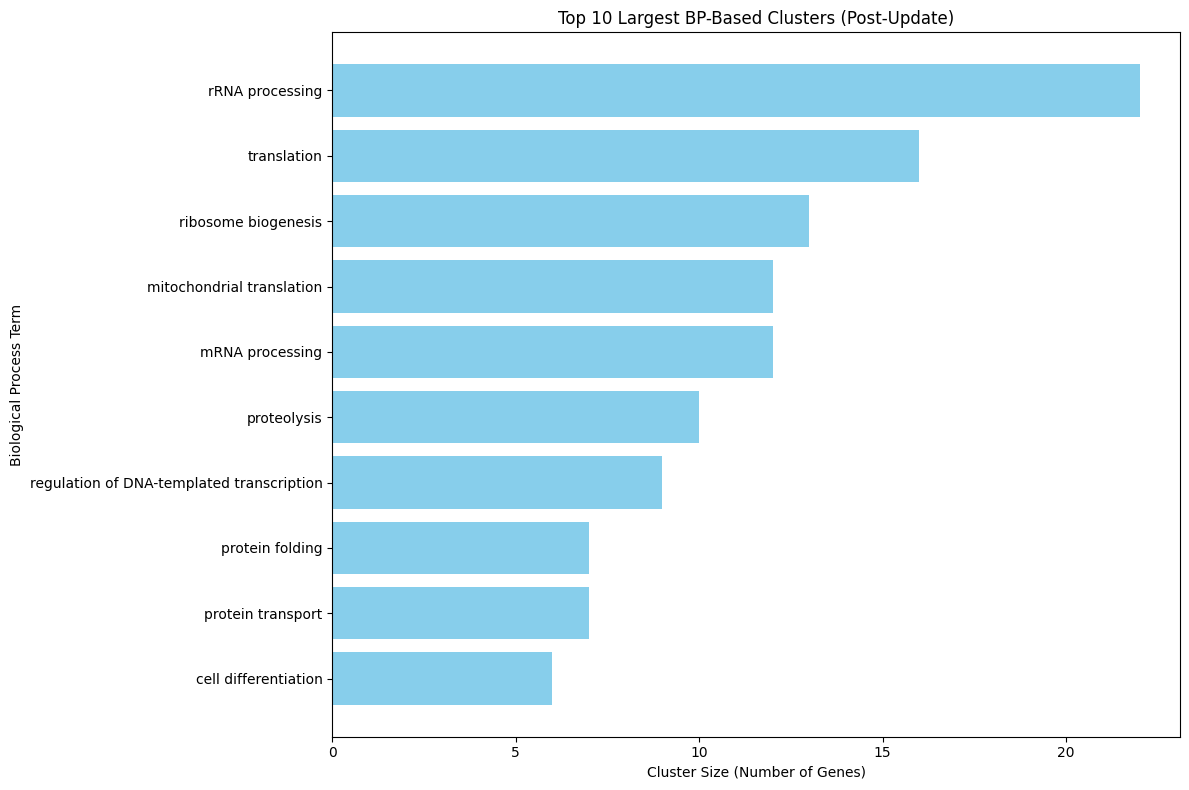

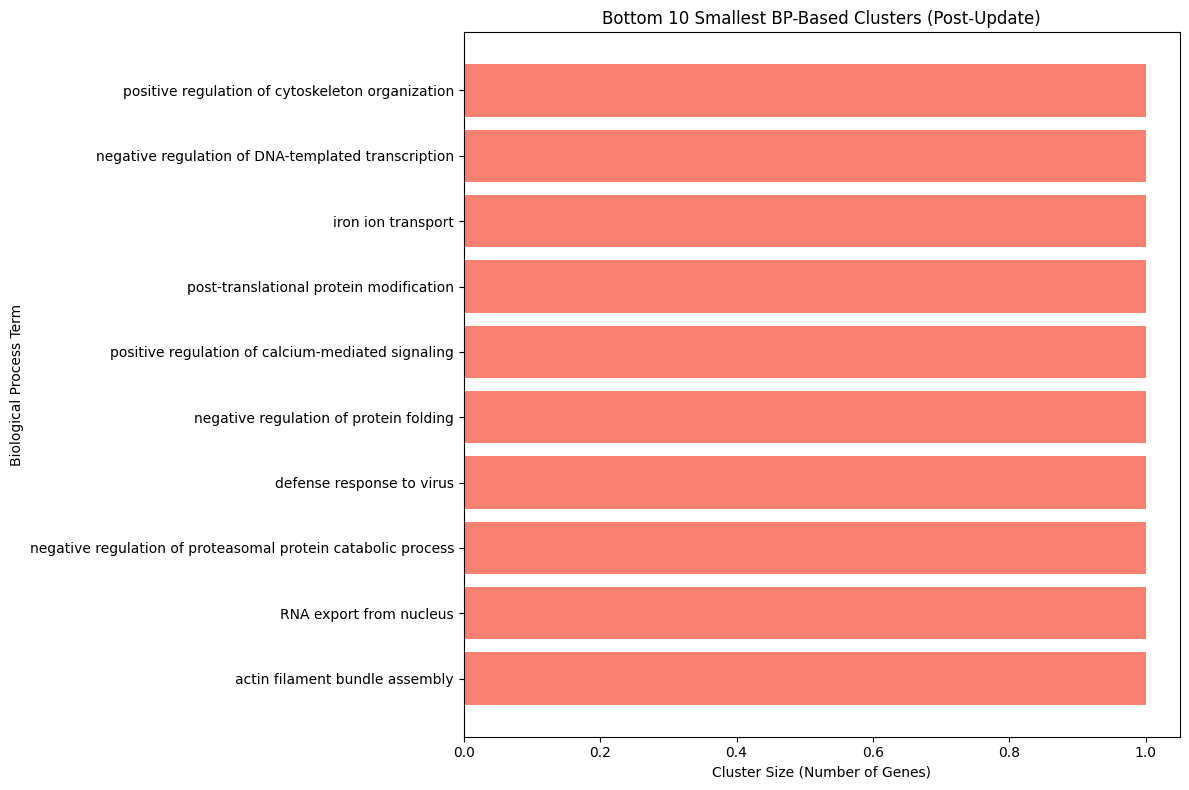

In [31]:
# --- Updated Workflow: Build Final DataFrame with Full Metadata ---

# Create a mapping from GO ID to its Term name
print("Creating 'go_to_term' mapping...")
go_to_term = bp_df[['GO_ID', 'Term']].drop_duplicates().set_index('GO_ID')['Term'].to_dict()
print("'go_to_term' created.")

# Create a map from each gene to the ACTIVE BPs it belongs to
print("\nCreating 'gene_to_active_bps' mapping...")
# First, get all BPs that are active in the regulatory network
active_bps = set(bp_reg_df['regulator_id']).union(set(bp_reg_df['target_id']))

# Filter the main BP dataframe for only these active BPs
active_bp_genes_df = bp_df[bp_df['GO_ID'].isin(active_bps)]

# Now, create the mapping from gene to its list of active BPs
gene_to_active_bps = active_bp_genes_df.groupby('Gene')['GO_ID'].apply(list).to_dict()
print("'gene_to_active_bps' created.")

# Re-initialize the list to hold our structured cluster data.
all_clusters_data = []

# --- Step 1: Add the newly formed "Grouped-Conflicted" clusters ---
# These are the clusters of size > 1 that we created from conflicted genes.
for cluster_genes in newly_formed_conflicted_clusters:
    # Since all genes in this cluster share the same BPs, we can just look up the first one.
    first_gene = cluster_genes[0]
    associated_bp_ids = gene_to_active_bps.get(first_gene, [])
    all_clusters_data.append({
        'cluster_type': 'Grouped-Conflicted',
        'genes': cluster_genes,
        'size': len(cluster_genes),
        'associated_BPs': [{'GO_ID': bp_id, 'Term': go_to_term.get(bp_id)} for bp_id in associated_bp_ids]
    })

# --- Step 2: Add the remaining "Singleton-Conflicted" genes ---
# These are the conflicted genes that could not be grouped.
# Note: We are using the updated 'conflicted_genes' variable here.
for gene in conflicted_genes:
    associated_bp_ids = gene_to_active_bps.get(gene, [])
    all_clusters_data.append({
        'cluster_type': 'Singleton-Conflicted',
        'genes': [gene],
        'size': 1,
        'associated_BPs': [{'GO_ID': bp_id, 'Term': go_to_term.get(bp_id)} for bp_id in associated_bp_ids]
    })

# --- Step 3: Add the original "BP-based" (unconflicted) clusters ---
# This logic is the same as before, but we ensure we use the *original* set of conflicted genes for filtering.
genes_by_bp = bp_df.groupby('GO_ID')['Gene'].apply(set)
for bp_id in active_bps:
    if bp_id in genes_by_bp:
        all_genes_in_bp = genes_by_bp[bp_id]
        # Use the original_conflicted_genes set to correctly identify unconflicted genes
        unconflicted_genes_in_bp = list(all_genes_in_bp - original_conflicted_genes)
        
        if unconflicted_genes_in_bp:
            all_clusters_data.append({
                'cluster_type': 'BP-based',
                'genes': unconflicted_genes_in_bp,
                'size': len(unconflicted_genes_in_bp),
                'associated_BPs': [{'GO_ID': bp_id, 'Term': go_to_term.get(bp_id)}]
            })

# --- Step 4: Convert to DataFrame and Display ---
all_clusters_df = pd.DataFrame(all_clusters_data)

print(f"Created a unified DataFrame with {len(all_clusters_df)} total clusters.")
print("\nBreakdown by Cluster Type:")
print(all_clusters_df['cluster_type'].value_counts())
print("\nDataFrame head:")
print(all_clusters_df.head())


# --- Step 5: Re-create Plots Using the New DataFrame ---

# The plotting code remains the same, as it correctly filters for 'BP-based' clusters.
bp_clusters_for_plotting_df = all_clusters_df[all_clusters_df['cluster_type'] == 'BP-based'].copy()
if not bp_clusters_for_plotting_df.empty:
    # The 'Term' is nested, so we need to extract it
    bp_clusters_for_plotting_df['Term'] = bp_clusters_for_plotting_df['associated_BPs'].apply(lambda x: x[0]['Term'] if x else 'N/A')

    # Plot Top 10 Largest BP-Based Clusters
    top_10 = bp_clusters_for_plotting_df.sort_values('size', ascending=False).head(10)
    plt.figure(figsize=(12, 8))
    plt.barh(top_10['Term'], top_10['size'], color='skyblue')
    plt.xlabel('Cluster Size (Number of Genes)')
    plt.ylabel('Biological Process Term')
    plt.title('Top 10 Largest BP-Based Clusters (Post-Update)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Plot Bottom 10 Smallest BP-Based Clusters
    bottom_10 = bp_clusters_for_plotting_df.sort_values('size', ascending=True).head(10)
    plt.figure(figsize=(12, 8))
    plt.barh(bottom_10['Term'], bottom_10['size'], color='salmon')
    plt.xlabel('Cluster Size (Number of Genes)')
    plt.ylabel('Biological Process Term')
    plt.title('Bottom 10 Smallest BP-Based Clusters (Post-Update)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No 'BP-based' clusters found to plot.")


In [56]:
all_clusters_df.head()

,cluster_type,genes,size,associated_BPs
0,Grouped-Conflicted,"[ENSG00000005075, ENSG00000102978, ENSG0000016...",4,"[{'GO_ID': 'GO:0006351', 'Term': 'DNA-template..."
1,Grouped-Conflicted,"[ENSG00000005302, ENSG00000154832]",2,"[{'GO_ID': 'GO:0006325', 'Term': 'chromatin or..."
2,Grouped-Conflicted,"[ENSG00000005801, ENSG00000160352, ENSG0000018...",6,"[{'GO_ID': 'GO:0006355', 'Term': 'regulation o..."
3,Grouped-Conflicted,"[ENSG00000008018, ENSG00000277791]",2,"[{'GO_ID': 'GO:0043161', 'Term': 'proteasome-m..."
4,Grouped-Conflicted,"[ENSG00000008988, ENSG00000145592]",2,"[{'GO_ID': 'GO:0002181', 'Term': 'cytoplasmic ..."


In [66]:
bp_based = all_clusters_df[all_clusters_df['cluster_type']=='BP-based']
bp_based

,cluster_type,genes,size,associated_BPs
2565,BP-based,"[ENSG00000259494, ENSG00000183617, ENSG0000015...",12,"[{'GO_ID': 'GO:0032543', 'Term': 'mitochondria..."
2566,BP-based,[ENSG00000134152],1,"[{'GO_ID': 'GO:0051495', 'Term': 'positive reg..."
2567,BP-based,[ENSG00000095564],1,"[{'GO_ID': 'GO:0045892', 'Term': 'negative reg..."
2568,BP-based,[ENSG00000087086],1,"[{'GO_ID': 'GO:0006826', 'Term': 'iron ion tra..."
2569,BP-based,[ENSG00000121579],1,"[{'GO_ID': 'GO:0043687', 'Term': 'post-transla..."
...,...,...,...,...
2704,BP-based,[ENSG00000182093],1,"[{'GO_ID': 'GO:0050808', 'Term': 'synapse orga..."
2705,BP-based,[ENSG00000205060],1,"[{'GO_ID': 'GO:0006111', 'Term': 'regulation o..."
2706,BP-based,[ENSG00000143294],1,"[{'GO_ID': 'GO:0051726', 'Term': 'regulation o..."
2707,BP-based,[ENSG00000178980],1,"[{'GO_ID': 'GO:0030218', 'Term': 'erythrocyte ..."


In [70]:
len(bp_based[bp_based['size']==1]), len(bp_based[bp_based['size']>1])

(91, 53)

In [39]:
all_clusters_df.cluster_type.unique()

array(['Grouped-Conflicted', 'Singleton-Conflicted', 'BP-based'],
      dtype=object)

In [34]:
len(all_clusters_df)

2709

In [72]:
len(all_clusters_df[all_clusters_df['cluster_type']=='Grouped-Conflicted'])

75

In [71]:
len(all_clusters_df[all_clusters_df['cluster_type']=='Singleton-Conflicted'])

2490

In [59]:
len(all_clusters_df[all_clusters_df['cluster_type']=='BP-based'])

144

In [53]:
bp_clusters_for_plotting_df.head()

,cluster_type,genes,size,associated_BPs,Term
2565,BP-based,[ENSG00000143742],1,"[{'GO_ID': 'GO:0045900', 'Term': 'negative reg...",negative regulation of translational elongation
2566,BP-based,[ENSG00000122378],1,"[{'GO_ID': 'GO:0045670', 'Term': 'regulation o...",regulation of osteoclast differentiation
2567,BP-based,[ENSG00000244462],1,"[{'GO_ID': 'GO:0043484', 'Term': 'regulation o...",regulation of RNA splicing
2568,BP-based,"[ENSG00000179091, ENSG00000198727, ENSG0000012...",6,"[{'GO_ID': 'GO:0045333', 'Term': 'cellular res...",cellular respiration
2569,BP-based,[ENSG00000122643],1,"[{'GO_ID': 'GO:0051607', 'Term': 'defense resp...",defense response to virus


In [42]:
len(updated_final_clusters)

2709

In [76]:
len(set([gene for cluster in updated_final_clusters for gene in cluster]))

3096

In [73]:
# Filter the DataFrame to get only the rows marked as 'Singleton-Conflicted'
conflicted_clusters_df = all_clusters_df[all_clusters_df['cluster_type'] == 'Singleton-Conflicted']

# The number of conflicted clusters is simply the number of rows in this filtered DataFrame
num_conflicted_clusters = len(conflicted_clusters_df)

print(f"Total number of conflicted clusters: {num_conflicted_clusters}")


Total number of conflicted clusters: 2490


In [74]:
# We start with the DataFrame of BP-based clusters from the previous step.
# Let's filter it to find only the clusters that are not singletons.
multi_gene_unconflicted_clusters_df = bp_clusters_for_plotting_df[bp_clusters_for_plotting_df['size'] > 1]


print("--- Statistics for Unconflicted, Multi-Gene Clusters (Size > 1) ---")

if multi_gene_unconflicted_clusters_df.empty:
    print("No BP-based clusters with more than one gene were found.")
else:
    # The 'size' column of our new DataFrame contains the data we need
    sizes = multi_gene_unconflicted_clusters_df['size']

    print(f"Total number of non-singleton BP-based clusters: {len(multi_gene_unconflicted_clusters_df)}")
    print(f"Total number of unique genes within these clusters: {sizes.sum()}")
    print(f"\nAverage cluster size: {sizes.mean():.2f}")
    print(f"Median cluster size: {sizes.median()}")
    print(f"Min cluster size (of this group): {sizes.min()}")
    print(f"Max cluster size: {sizes.max()}")


--- Statistics for Unconflicted, Multi-Gene Clusters (Size > 1) ---
Total number of non-singleton BP-based clusters: 53
Total number of unique genes within these clusters: 239

Average cluster size: 4.51
Median cluster size: 3.0
Min cluster size (of this group): 2
Max cluster size: 22
